In [1]:
import torch
import torchvision

In [2]:
import settings
from loader.model_loader import loadmodel
from feature_operation import hook_feature,FeatureOperator
from visualize.report import generate_html_summary
from util.clean import clean

In [ ]:
print(settings.DATASET)
print(settings.BATCH_SIZE)

In [3]:

import os
from torch.autograd import Variable as V
from PIL import Image
# from scipy.misc import imresize
import numpy as np
import torch
import settings
import time
import util.upsample as upsample
import util.vecquantile as vecquantile
import multiprocessing.pool as pool
from loader.data_loader import load_csv
from loader.data_loader import SegmentationData, SegmentationPrefetcher

features_blobs = []
start_unit = 180
end_unit = 190
def hook_feature(module, input, output):
#     print("Hooking module named ",module.name)
    features_blobs.append(output.data.cpu().numpy()[:,start_unit:end_unit,:,:])


In [ ]:

    

model_file = "checkpoints/resnet18-200-regular.pth"
# model_file = "zoo/resnet18_places365.pth.tar"
# path = "iter200"
# fo = FeatureOperator(path)
print("Loading model file ",model_file)
# model = loadmodel(hook_feature,model_file)
# model = loadmodel(hook_feature,model_file)
checkpoint = torch.load(model_file)
model = torchvision.models.__dict__[settings.MODEL](num_classes=settings.NUM_CLASSES)
model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model.maxpool = torch.nn.Identity()
state_dict = checkpoint
model.load_state_dict(state_dict)
model.cuda()
model.eval()

In [ ]:
from loader.data_loader import load_csv
import settings
from loader.data_loader import SegmentationData, SegmentationPrefetcher
print(settings.DATA_DIRECTORY)
data = SegmentationData(settings.DATA_DIRECTORY, categories=settings.CATAGORIES)
loader = SegmentationPrefetcher(data,categories=['image'],once=True,batch_size=settings.BATCH_SIZE)
mean = [109.5388,118.6897,124.6901]

In [ ]:
num_batches = (len(loader.indexes) + loader.batch_size - 1) / loader.batch_size
print(num_batches)
print(model._modules.get("layer4"))
model._modules.get("layer4").register_forward_hook(hook_feature)
print(len(loader.indexes))

In [ ]:
maxfeatures = [None] * len(settings.FEATURE_NAMES) #Max activation in the channel (broden_size,no.of channels)
wholefeatures = [None] * len(settings.FEATURE_NAMES) #All the activations (broden_size,no.of channels,h,w)
features_size = [None] * len(settings.FEATURE_NAMES)
memmap=True
for batch_idx,batch in enumerate(loader.tensor_batches(bgr_mean=mean)):
        del features_blobs[:]
        torch.cuda.empty_cache()
        input = batch[0]
        batch_size = len(input)
        print('extracting feature from batch %d / %d' % (batch_idx+1, num_batches))
        input = torch.from_numpy(input[:, ::-1, :, :].copy())
        input.div_(255.0 * 0.224)
        if settings.GPU:
            input = input.cuda()
        input_var = V(input,volatile=True)
        logit = model.forward(input_var)  
#         if(batch_idx>2):break
        #Initializing the feature variables
        print("Feature Blobs length ",len(features_blobs))
        print("First blob",np.shape(features_blobs[0]))
        if maxfeatures[0] is None:
            # initialize the feature variable
            for i, feat_batch in enumerate(features_blobs):
                print("Initializing %d"%i)
                size_features = (len(loader.indexes), feat_batch.shape[1])
                if memmap:
                    maxfeatures[i] = np.memmap('cifar100_actual_Max_features.mmap',dtype=float,mode='w+',shape=size_features)
                else:
                    maxfeatures[i] = np.zeros(size_features)
                    
        #Initializing the all feature variable
        if len(feat_batch.shape) == 4 and wholefeatures[0] is None:
            # initialize the feature variable
            for i, feat_batch in enumerate(features_blobs):
                size_features = (
                len(loader.indexes), feat_batch.shape[1], feat_batch.shape[2], feat_batch.shape[3])
                features_size[i] = size_features
                if memmap:
                    wholefeatures[i] = np.memmap('cifar100_actual_Whole_features.mmap', dtype=float, mode='w+', shape=size_features)
                else:
                    wholefeatures[i] = np.zeros(size_features)
                    
        np.save("test_feature_size.npy", features_size)
        start_idx = batch_idx*settings.BATCH_SIZE
        end_idx = min((batch_idx+1)*settings.BATCH_SIZE, len(loader.indexes))
        for i, feat_batch in enumerate(features_blobs):
            if len(feat_batch.shape) == 4:
                wholefeatures[i][start_idx:end_idx] = feat_batch
                maxfeatures[i][start_idx:end_idx] = np.max(np.max(feat_batch,3),2)
            elif len(feat_batch.shape) == 3:
                maxfeatures[i][start_idx:end_idx] = np.max(feat_batch, 2)
            elif len(feat_batch.shape) == 2:
                maxfeatures[i][start_idx:end_idx] = feat_batch
#     if len(feat_batch.shape) == 2:
#         wholefeatures = maxfeatures
#     return wholefeatures,maxfeatures

In [ ]:
feature_size = np.load("test_feature_size.npy")
print(feature_size)
wholefeatures = np.memmap("Places_Whole_features.mmap", dtype=float,mode='r', shape=tuple(feature_size[0]))

In [ ]:
print(np.shape(wholefeatures))
fo = FeatureOperator("Places_test")
thresh = fo.quantile_threshold(wholefeatures)

In [ ]:
csvpath = "Test_tally.csv"
features = wholefeatures
print(features.shape)
units = features.shape[1]
print(units)
labels = len(data.label)
categories = data.category_names()
print(categories)
tally_both = np.zeros((units,labels),dtype=np.float64)
tally_units = np.zeros(units,dtype=np.float64)
tally_units_cat = np.zeros((units,len(categories)), dtype=np.float64)
tally_labels = np.zeros(labels,dtype=np.float64)
print("Tally labels",np.shape(tally_labels))
print("Tally units",np.shape(tally_units))
print("Tally both",np.shape(tally_both))
print("Tally cat units",np.shape(tally_units_cat))
primary_categories = data.primary_categories_per_index()
tally_units_cat = np.dot(tally_units_cat, data.labelcat.T) #

print("Primary categories",primary_categories)
iou = tally_both / (tally_units_cat + tally_labels[np.newaxis,:] - tally_both + 1e-10)
print("IOU",np.shape(iou))
pciou = np.array([iou * (primary_categories[np.arange(iou.shape[1])] == ci)[np.newaxis, :] for ci in range(len(data.category_names()))])
print(data.size)
print("PCIOU",np.shape(pciou))
primary_categories = data.primary_categories_per_index()
label_pciou = pciou.argmax(axis=2)
print("Label PCIOU",np.shape(label_pciou))
score_pciou = pciou[
            np.arange(pciou.shape[0])[:, np.newaxis],
            np.arange(pciou.shape[1])[np.newaxis, :],
            label_pciou]
print("Score PCIOU",np.shape(score_pciou))
label_cat = data.labelcat
print(primary_categories)
print(label_cat)
print(np.shape(label_cat))
print(len(primary_categories))
print(data.name(None,2))

In [ ]:
units = features.shape[1] #depth or number of channels (512 for res18 layer 4)
size_RF = (settings.IMG_SIZE / features.shape[2], settings.IMG_SIZE / features.shape[3]) #Broden size/ feature map size = (224/7,224,7)
fieldmap = ((0, 0), size_RF, size_RF) #((0,0),(32,32),(32,32))
print(fieldmap)
start = 0
end = data.size()
print("Start %d ,End %d"%(start,end))
pd = SegmentationPrefetcher(data, categories=data.category_names(),
                            once=True, batch_size=settings.TALLY_BATCH_SIZE,
                                    ahead=settings.TALLY_AHEAD, start=start, end=end)

In [ ]:
count = start
img = None
img_path = ""
for batch in pd.batches():
    print(count)
    for concept_map in batch:
        img_index = concept_map['i']
        for key,val in concept_map.items():
            print(key,val)
        count+=1
        if(concept_map["scene"]!=[]):
            object_img = concept_map['object']
            color_img = concept_map["color"]
            part_img = concept_map["part"]
            scence_img = concept_map["scene"]
            img_path = concept_map['fn']
#         print(concept_map.keys())
#         print(img_index)
    break


In [ ]:
tally_result = fo.tally(features,thresh,savepath="tally.csv")


In [ ]:
unit_1=None
for res in tally_result:
    if(res["unit"]==1):unit_1 = res
        
for key,vals in unit_1.items():
    print(key,vals)

In [20]:
it = 100
path = "resnet18_cifar100_featuremaps/"
max_path = path+"cifar100_actual_Max_features-iter_%d.mmap"%it
whole_path = path+"cifar100_actual_Whole_features-iter_100.mmap"
size_features = np.load("test_feature_size.npy")[0]
print(size_features[0])
print(tuple(size_features))
features= np.memmap(whole_path, dtype=float, mode='r',shape = tuple(size_features))
print(np.shape(features))
maxfeature = np.memmap(max_path, dtype=float, mode='r', shape=tuple(size_features[:2]))
print(np.shape(maxfeature))

63305
(63305, 10, 28, 28)
(63305, 10, 28, 28)
(63305, 10)


(224, 2267, 3)
(224, 2267, 3)
(224, 2267, 3)
(224, 2267, 3)


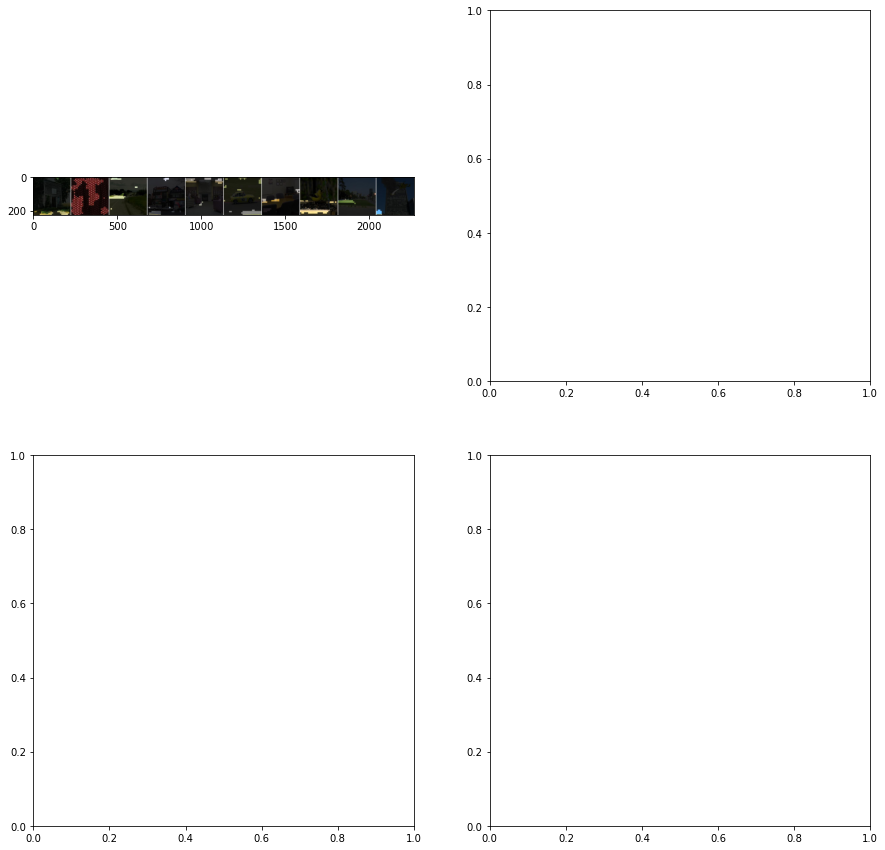

In [23]:
from PIL import Image
import matplotlib.pyplot as plt
iters = [50,100,150,200]
fig,ax = plt.subplots(2,2,figsize=(15,15))
c = 0
for it in iters:
    path = "resnet18_cifar100_featuremaps/iter%d/html/image/layer4-0005.jpg"%it
    X = Image.open(path)
    print(np.shape(X))
    ax[c//2,c%2].imshow(X)
    # print(scence_img)
# ax[1].imshow(object_img.reshape((112,112)))
# ax[1].imshow(color_img.reshape((112,112)))
# ax[1].imshow(part_img.reshape((112,112)))
# ax[1].imshow(scence_img.reshape((112,112)))
plt.show()